In [1]:
%pwd

'd:\\AnalyticsX\\Mura_models\\Workflow\\research'

In [2]:
import os
os.chdir("../")

In [3]:
%pwd

'd:\\AnalyticsX\\Mura_models\\Workflow'

In [4]:
from skimage.filters import gaussian as gaussian2,laplace as laplace2
import numpy as cp
import scipy.ndimage as ndimage
import skimage.exposure as exposure2
from PIL import Image
import matplotlib.pyplot as plt
import cv2
import torch
import torchvision.transforms as transforms



In [26]:
valid_transforms = transforms.Compose([
    transforms.ToTensor(),
    transforms.Grayscale(),
    transforms.Resize((224, 224)),
    #ToArray(to_array = 'cupy'),
    #Enhance(),
])

In [27]:
def unsharp_mask(image):
    # Calculate the high-pass filtered image (unsharp mask)
    high_pass = laplace2(gaussian2(image, sigma=5, mode='reflect'))

    # Apply a threshold to highlight only weaker edges
    high_pass_thresholded = cp.where((high_pass >= 0), high_pass, cp.mean(high_pass))

    # Normalize the values to the range [0, 255]
    sharpened_image = (high_pass_thresholded - cp.min(high_pass_thresholded)) * 255 / (cp.max(high_pass_thresholded) - cp.min(high_pass_thresholded))

    # Clip the values to ensure they are within the valid range [0, 255]
    sharpened_image = cp.clip(sharpened_image, 0, 255)

    return sharpened_image.astype(cp.uint8)

def image_preprocessing(image,step_1 = False):
    
    image = valid_transforms(image)
    image  = image *255

    # Gaussian filtering with different sigma values
    gaussian_50 = cp.clip(cp.clip(image - gaussian2(image, sigma = 50, mode = 'reflect'), 0, 255), 0, 255)
    gaussian_150 = cp.clip(image - gaussian2(image, sigma = 150, mode = 'reflect'), 0, 255)
    gaussian_200 = cp.clip(image - gaussian2(image, sigma = 200, mode = 'reflect'), 0, 255)



    # Kernel sharpening for intermediate strength edges
    if step_1:
      high_pass_image = unsharp_mask(image)
      high_pass_image = exposure2.match_histograms(high_pass_image)

    # Combine sharpened Gaussian filtered images

      combined_image = (gaussian_50 +
                      gaussian_150 + gaussian_200 + high_pass_image)/4/255
    else:
      combined_image =(gaussian_50 +
                      gaussian_150 + gaussian_200) / 3/255
  
    



    return combined_image


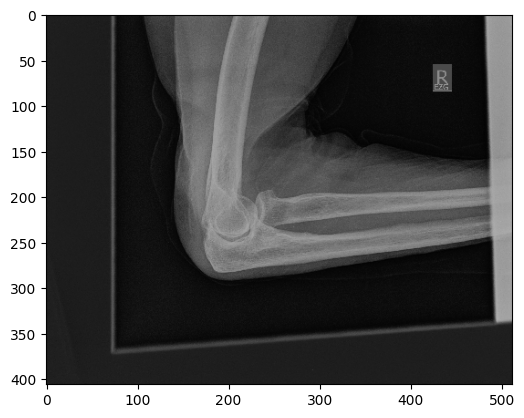

In [28]:
test = Image.open("image2.png")
ref= Image.open("Reference_bone_image.jpg")
plt.imshow(test)

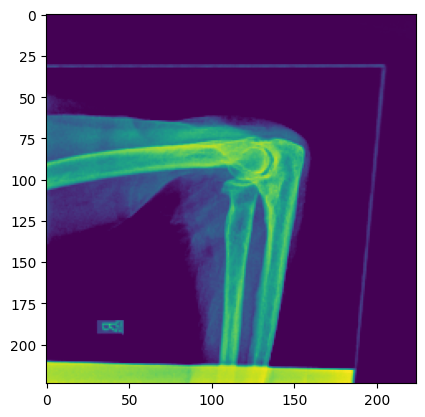

In [29]:
test1= image_preprocessing(test)
plt.imshow(test1.T)

In [30]:
model=torch.load("model\ECN_MURA.pth",map_location=torch.device('cpu'))

<>:1: SyntaxWarning: invalid escape sequence '\E'
<>:1: SyntaxWarning: invalid escape sequence '\E'
C:\Users\bprav\AppData\Local\Temp\ipykernel_1620\1317401470.py:1: SyntaxWarning: invalid escape sequence '\E'
  model=torch.load("model\ECN_MURA.pth",map_location=torch.device('cpu'))


In [31]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable

In [32]:
from torchvision.models import densenet169,DenseNet169_Weights

In [33]:
class PartialDenseNet(nn.Module):
    def __init__(self, original_model, end_layer_name):
        super(PartialDenseNet, self).__init__()
        self.features = nn.Sequential()
        for name, module in original_model.features.named_children():
            if name == end_layer_name:
                break
            
            self.features.add_module(name, module)
            
    
    def forward(self, x):
        x = self.features(x)
        return x

In [34]:
end_layer_name = 'transition3' 

In [35]:
initial_model = densenet169(weights='DEFAULT')

# Extract the weights from the first layer
first_conv_layer = initial_model.features.conv0
weights = first_conv_layer.weight.data

# Sum the weights across the three input channels
grayscale_weights = torch.sum(weights, dim=1, keepdim=True)

# Create a new convolutional layer that accepts grayscale images
new_first_conv_layer = nn.Conv2d(
    in_channels=1,  # Grayscale image has 1 channel
    out_channels=first_conv_layer.out_channels,
    kernel_size=first_conv_layer.kernel_size,
    stride=first_conv_layer.stride,
    padding=first_conv_layer.padding,
    bias=(first_conv_layer.bias is not None)
)

# Initialize the new layer with the grayscale weights
new_first_conv_layer.weight.data = grayscale_weights

# If the original layer had a bias, initialize it as well
if first_conv_layer.bias is not None:
    new_first_conv_layer.bias.data = first_conv_layer.bias.data

# Replace the first convolutional layer in the DenseNet with the new layer
initial_model.features.conv0 = new_first_conv_layer


pd = PartialDenseNet(initial_model, end_layer_name)


In [36]:
'''if name == 'conv0':
                conv0 = nn.Conv2d(in_channels = 1, out_channels = 64, kernel_size = 3, padding = 1, stride = 2)
                self.features.add_module(name, conv0)
                continue
            
            elif 'pool' in name:
                downsampler = nn.Conv2d(in_channels = 64, out_channels = 64, kernel_size = 3, padding = 1, stride = 2)
                self.features.add_module(name, downsampler)
                continue
            elif 'transition' in name and '3' not in name:
                Transition = nn.Sequential()
                channels = 64
                for name2, submodule in module.named_children():
                    if 'conv' in name2:
                        channels = submodule.out_channels
                    if 'pool' in name2:
                        downsampler = nn.Conv2d(in_channels = channels, out_channels = channels, stride = 2, kernel_size = 3, padding = 1, groups = channels//8)
                        Transition.add_module(name2, downsampler)
                        continue
                    Transition.add_module(name2, submodule)    
                self.features.add_module(name, Transition)        
                continue
            if 'denseblock' in name:
                self.features.add_module(f'{name}_dropout', nn.Dropout(p=dropout_prob))'''

"if name == 'conv0':\n                conv0 = nn.Conv2d(in_channels = 1, out_channels = 64, kernel_size = 3, padding = 1, stride = 2)\n                self.features.add_module(name, conv0)\n                continue\n            \n            elif 'pool' in name:\n                downsampler = nn.Conv2d(in_channels = 64, out_channels = 64, kernel_size = 3, padding = 1, stride = 2)\n                self.features.add_module(name, downsampler)\n                continue\n            elif 'transition' in name and '3' not in name:\n                Transition = nn.Sequential()\n                channels = 64\n                for name2, submodule in module.named_children():\n                    if 'conv' in name2:\n                        channels = submodule.out_channels\n                    if 'pool' in name2:\n                        downsampler = nn.Conv2d(in_channels = channels, out_channels = channels, stride = 2, kernel_size = 3, padding = 1, groups = channels//8)\n                       

In [37]:
def freeze_parameters(model, unfrozen_layers):
    for name, param in model.named_parameters():
        if not any(layer in name for layer in unfrozen_layers):
             param.requires_grad = False

In [38]:
'''class ConvLayer(nn.Module):
  def __init__(self):
    super(ConvLayer, self).__init__() # input is MURA (batch, 1, 224, 224)
    self.conv1 = nn.Conv2d(in_channels = 1, out_channels = 2, kernel_size = 25, stride = 1, padding = 0) # (batch, 2, 200, 200), 
    self.conv2 = nn.Conv2d(in_channels = 2, out_channels = 4, kernel_size = 25, stride = 1, padding = 0) #(batch, 4, 176, 176), 
    self.conv3 = nn.Conv2d(in_channels = 4, out_channels = 8, kernel_size = 25, stride = 1, padding = 0) # (batch, 8, 154, 154)
    self.conv4 = nn.Conv2d(in_channels = 8, out_channels = 16, kernel_size = 25, stride = 1, padding = 0) #(batch, 16, 130, 130)
    self.conv5 = nn.Conv2d(in_channels = 16, out_channels = 32, kernel_size = 25, stride = 1, padding = 0, groups = 2) #(batch, 16, 106, 106)
    self.conv6 = nn.Conv2d(in_channels = 32, out_channels = 64, kernel_size = 25, stride = 1, padding = 0, groups = 4) #(batch, 16, 82, 82)
    self.conv7 = nn.Conv2d(in_channels = 64, out_channels = 128, kernel_size = 25, stride = 1, padding = 0, groups = 8) #(batch, 16, 58, 58)
    self.conv8 = nn.Conv2d(in_channels = 128, out_channels = 256, kernel_size = 25, stride = 1, padding = 0, groups = 16) #(batch, 16, 32, 32)
    self.conv9 = nn.Conv2d(in_channels = 256, out_channels = 512, kernel_size = 5, stride = 1, padding = 0, groups = 32) #(batch, 128, 28, 28)

    self.bn1 = nn.BatchNorm2d(num_features = 2)
    self.bn2 = nn.BatchNorm2d(num_features = 4)
    self.bn3 = nn.BatchNorm2d(num_features = 8)
    self.bn4 = nn.BatchNorm2d(num_features = 16)
    self.bn5 = nn.BatchNorm2d(num_features = 32)
    self.bn6 = nn.BatchNorm2d(num_features = 64)
    self.bn7 = nn.BatchNorm2d(num_features = 128)
    self.bn8 = nn.BatchNorm2d(num_features = 256)
    self.bn9 = nn.BatchNorm2d(num_features = 512)


    self.reset_parameters()

  def forward(self, x):
    x = F.relu(self.bn1(self.conv1(x)))
    x = F.relu(self.bn2(self.conv2(x)))
    x = F.relu(self.bn3(self.conv3(x)))
    x = F.relu(self.bn4(self.conv4(x)))
    x = F.relu(self.bn5(self.conv5(x)))
    x = F.relu(self.bn6(self.conv6(x)))
    x = F.relu(self.bn7(self.conv7(x)))
    x = F.relu(self.bn8(self.conv8(x)))
    x = F.relu(self.bn9(self.conv9(x)))
    return x

  def reset_parameters(self):
    for m in self.modules():
      if isinstance(m, nn.Conv2d):
        nn.init.kaiming_normal_(m.weight, nonlinearity="relu")
'''        
class ConvLayer(nn.Module):
  def __init__(self):
    super(ConvLayer, self).__init__() # input is MURA (batch, 1, 224, 224), MNIST (batch, 3, 28, 28)
    self.conv1 = nn.Conv2d(in_channels = 1, out_channels = 32, kernel_size = 7, stride = 2, padding = 0) # (batch, 32, 109, 109), (batch, 32, 24, 24)
    self.conv2 = nn.Conv2d(in_channels = 32, out_channels = 64, kernel_size = 5, stride = 2, padding = 0) #(batch, 64, 52, 52), (batch, 64, 22, 22)
    self.conv3 = nn.Conv2d(in_channels = 64, out_channels = 128, kernel_size = 5, stride = 2, padding = 0) # (batch, 64, 24, 24), (batch, 64, 20, 20)
    self.conv4 = nn.Conv2d(in_channels = 128, out_channels = 256, kernel_size = 5, stride = 2, padding = 0) #(batch, 128, 7, 7), (batch, 128, 9, 9)
    self.conv5 = nn.Conv2d(in_channels = 256, out_channels = 512, kernel_size = 5, stride = 1, padding = 0, groups = 2)

    self.bn1 = nn.BatchNorm2d(num_features = 32)
    self.bn2 = nn.BatchNorm2d(num_features = 64)
    self.bn3 = nn.BatchNorm2d(num_features = 128)
    self.bn4 = nn.BatchNorm2d(num_features = 256)
    self.bn5 = nn.BatchNorm2d(num_features = 512)

    self.reset_parameters()

  def forward(self, x):
    x = F.relu(self.bn1(self.conv1(x)))
    x = F.relu(self.bn2(self.conv2(x)))
    x = F.relu(self.bn3(self.conv3(x)))
    x = F.relu(self.bn4(self.conv4(x)))
    x = F.relu(self.bn5(self.conv5(x)))
    return x

  def reset_parameters(self):
    for m in self.modules():
      if isinstance(m, nn.Conv2d):
        nn.init.kaiming_normal_(m.weight, nonlinearity="relu")


'''
class DepthWiseConv(nn.Module):
  def __init__(self,capsule_size = (64, 8), kernel_size = 3, dropout_rate = 0.0):
    super(DepthWiseConv, self).__init__()
    self.num_capsules, self.dim_capsules = capsule_size
    self.dwc1 = nn.Conv2d(in_channels = self.num_capsules * self.dim_capsules, out_channels = self.num_capsules * self.dim_capsules, kernel_size = 9, groups = 32 , padding = 0)
    self.dropout1 = nn.Dropout(dropout_rate)
    self.dwc2 = nn.Conv2d(in_channels = self.num_capsules * self.dim_capsules, out_channels = self.num_capsules * self.dim_capsules, kernel_size = 11, groups = 128 , padding = 0)
    self.dropout2 = nn.Dropout(dropout_rate)
    self.dwc3 = nn.Conv2d(in_channels = self.num_capsules * self.dim_capsules, out_channels = self.num_capsules * self.dim_capsules, kernel_size = 10, groups = self.num_capsules * self.dim_capsules , padding = 0)
    self.dropout3 = nn.Dropout(dropout_rate)
    self.reset_parameters()

  def reset_parameters(self):
    for m in self.modules():
      if isinstance(m, nn.Conv2d):
        nn.init.kaiming_normal_(m.weight, nonlinearity="relu")

  def forward(self, x):
    x = self.dwc1(x)
    x = self.dropout1(x)
    x = x.view(-1, self.num_capsules, self.dim_capsules)
    x = self.squash(x)
    x = x.view(-1, self.num_capsules*self.dim_capsules, 20, 20)
    x = self.dwc2(x)
    x = self.dropout2(x)
    x = x.view(-1, self.num_capsules, self.dim_capsules)
    x = self.squash(x)
    x = x.view(-1, self.num_capsules*self.dim_capsules, 10, 10)
    x = self.dwc3(x)
    x = self.dropout3(x)
    x = x.view(-1, self.num_capsules, self.dim_capsules)
    x = self.squash(x)
    return x

  def squash(self, x):
    eps = 1e-20
    norm = torch.linalg.norm(x, ord = 2, dim = -1, keepdim = True)
    coef = norm**2/(1+norm**2)
    unit = x / (norm + eps)
    return coef * unit


class FCCaps(nn.Module):
    def __init__(self, num_capsules=2, dim_capsules=500, kernel_initializer='he_normal', input_shape=(64, 20), dropout_rate = 0.0):
        super(FCCaps, self).__init__()
        self.num_capsules = num_capsules
        self.dim_capsules = dim_capsules
        input_num_cap = input_shape[-2]  # Number of capsules in the previous layer
        input_dim_cap = input_shape[-1]  # Dimension of capsules in the previous layer
        
        self.W = nn.Parameter(torch.randn(self.num_capsules,input_num_cap, input_dim_cap, self.dim_capsules))  # (num_capsules, input_num_cap, input_dim_cap, dim_capsules)
        nn.init.kaiming_normal_(self.W, mode='fan_in', nonlinearity='leaky_relu')

        self.b = nn.Parameter(torch.zeros(self.num_capsules, input_num_cap, 1))
        self.dropout = nn.Dropout(dropout_rate)
    def forward(self, x):
        # Compute u_hat
        batch_size = x.size(0)
        u = torch.einsum('...ji,kjiz->...kjz',x,self.W)  # (batch_size, self.num_capsules, input_num_cap , self.dim_capsules)
        c = torch.einsum('...ij,...kj->...i', u, u).unsqueeze(-1)
        c = c / torch.sqrt(torch.tensor(self.dim_capsules, dtype=torch.float32))
        c = F.softmax(c, dim=1)  # Shape=(None, N, H*W*input_N, 1)
        c = c + self.b
        s = torch.sum(u * c, dim=-2)  # Shape=(batch_size, self.num_capsules, self.dim_capsules)
        s = self.dropout(s)
        v = self.squash(s)
        
        return v

    def squash(self, x):
        eps = 1e-20
        norm = torch.linalg.norm(x, ord = 2, dim = -1, keepdim = True)
        coef = norm**2/(1+norm**2)
        unit = x / (norm + eps)
        return coef * unit
    
class CapsLen(nn.Module):
    def __init__(self, eps=1e-10):
        super(CapsLen, self).__init__()
        self.eps = eps

    def forward(self, x):
        return torch.sqrt(
            torch.sum(x**2, dim=-1) + self.eps
        )

class CapsMask(nn.Module):
    def __init__(self):
        super(CapsMask, self).__init__()
        

    def forward(self, x, x_prime, y_true=None):
        if y_true is not None:  # training mode
            mask = y_true
        else:  # testing mode
            # convert list of maximum value's indices to one-hot tensor
            temp = x_prime
            mask = F.one_hot(torch.argmax(temp, dim=1), num_classes=temp.shape[1])
        masked = torch.sum(x * mask.unsqueeze(-1), dim = 1)
        return masked.squeeze(1)  # reshape
    
class EfficientCapsNet(nn.Module):
  def __init__(self, input_size = (1, 224, 224)):
    super(EfficientCapsNet, self).__init__()
    self.convlayer = ConvLayer()
    self.primarycaps = DepthWiseConv()
    self.routingcaps1 = FCCaps(num_capsules = 2, dim_capsules = 50, input_shape = (64, 8))
    
  
  def forward(self, x):
    x = self.convlayer(x)
    x = self.primarycaps(x)
    x = self.routingcaps1(x)
    
    return x


class ReconstructionNet(nn.Module):
  def __init__(self, input_size = (1, 224, 224), num_classes = 2, num_capsules = 2, dim_capsules = 50, seq_len = 7):
    super(ReconstructionNet, self).__init__()
    self.input_size = input_size
    self.num_capsules = num_capsules
    self.dim_capsules = dim_capsules
    self.num_channels = 128
    self.seq_len = 7
    self.decoder = nn.Sequential(
            nn.Linear(dim_capsules, self.num_channels*self.seq_len*self.seq_len),
            nn.ReLU(inplace=True),
            nn.Unflatten(1, (self.num_channels, self.seq_len, self.seq_len)),
            nn.ConvTranspose2d(self.num_channels, self.num_channels//4, kernel_size=4, stride=2, padding=1),
            nn.ReLU(inplace=True),
            nn.ConvTranspose2d(self.num_channels//4, self.num_channels//8, kernel_size=4, stride=2, padding=1),
            nn.ReLU(inplace=True),
            nn.ConvTranspose2d(self.num_channels//8, self.num_channels//32, kernel_size=4, stride=2, padding=1),
            nn.ReLU(inplace=True),
            nn.ConvTranspose2d(self.num_channels//32, 2, kernel_size=4, stride=2, padding=1),
            nn.ReLU(inplace=True),
            nn.ConvTranspose2d(2, 1, kernel_size=4, stride=2, padding = 1)
            )
    self.reset_parameters()

  def forward(self, x):
    batch_size = x.size(0)
    #x = x.view(batch_size, self.dim_capsules, self.seq_len, self.seq_len)
    x = self.decoder(x)
    return x

  def reset_parameters(self):
    for layer in self.decoder:
      if isinstance(layer, nn.Linear):
        nn.init.kaiming_normal_(layer.weight, mode='fan_out', nonlinearity='relu')
        if layer.bias is not None:
          nn.init.constant_(layer.bias, 0)
      elif isinstance(layer, nn.ConvTranspose2d):
        nn.init.kaiming_normal_(layer.weight, mode='fan_out', nonlinearity='relu')
        if layer.bias is not None:
          nn.init.constant_(layer.bias, 0)


class FinalCapsNet(nn.Module):
    def __init__(self):
        super(FinalCapsNet, self).__init__()
        self.efficient_capsnet = EfficientCapsNet()
        self.mask = CapsMask()
        self.len_caps = CapsLen()
        self.generator = ReconstructionNet()

    def forward(self, x, y_true=None, mode= 'train'):
        x = self.efficient_capsnet(x)
        x_prime = self.len_caps(x)
        if mode == "train":
            masked = self.mask(x,x_prime, y_true)
        elif mode == "eval":
            masked = self.mask(x,x_prime)
        x = self.generator(masked)
        return x, x_prime'''

'\nclass DepthWiseConv(nn.Module):\n  def __init__(self,capsule_size = (64, 8), kernel_size = 3, dropout_rate = 0.0):\n    super(DepthWiseConv, self).__init__()\n    self.num_capsules, self.dim_capsules = capsule_size\n    self.dwc1 = nn.Conv2d(in_channels = self.num_capsules * self.dim_capsules, out_channels = self.num_capsules * self.dim_capsules, kernel_size = 9, groups = 32 , padding = 0)\n    self.dropout1 = nn.Dropout(dropout_rate)\n    self.dwc2 = nn.Conv2d(in_channels = self.num_capsules * self.dim_capsules, out_channels = self.num_capsules * self.dim_capsules, kernel_size = 11, groups = 128 , padding = 0)\n    self.dropout2 = nn.Dropout(dropout_rate)\n    self.dwc3 = nn.Conv2d(in_channels = self.num_capsules * self.dim_capsules, out_channels = self.num_capsules * self.dim_capsules, kernel_size = 10, groups = self.num_capsules * self.dim_capsules , padding = 0)\n    self.dropout3 = nn.Dropout(dropout_rate)\n    self.reset_parameters()\n\n  def reset_parameters(self):\n    for m

In [39]:
class ConvLayer(nn.Module):
  def __init__(self):
    super(ConvLayer, self).__init__() # input is MURA (batch, 1, 224, 224)
    self.conv1 = nn.Conv2d(in_channels = 1, out_channels = 2, kernel_size = 25, stride = 1, padding = 0) # (batch, 2, 200, 200), 
    self.conv2 = nn.Conv2d(in_channels = 2, out_channels = 4, kernel_size = 25, stride = 1, padding = 0) #(batch, 4, 176, 176), 
    self.conv3 = nn.Conv2d(in_channels = 4, out_channels = 8, kernel_size = 25, stride = 1, padding = 0) # (batch, 8, 152, 152)
    self.conv4 = nn.Conv2d(in_channels = 8, out_channels = 16, kernel_size = 25, stride = 1, padding = 0) #(batch, 16, 128, 128)
    self.conv5 = nn.Conv2d(in_channels = 16, out_channels = 32, kernel_size = 25, stride = 1, padding = 0, groups = 2) #(batch, 32, 104, 104)
    self.conv6 = nn.Conv2d(in_channels = 32, out_channels = 64, kernel_size = 25, stride = 1, padding = 0, groups = 4) #(batch, 64, 80, 80)
    self.conv7 = nn.Conv2d(in_channels = 64, out_channels = 128, kernel_size = 25, stride = 1, padding = 0, groups = 8) #(batch, 128, 56, 56)
    self.conv8 = nn.Conv2d(in_channels = 128, out_channels = 256, kernel_size = 25, stride = 1, padding = 0, groups = 16) #(batch, 256, 32, 32)
    self.conv9 = nn.Conv2d(in_channels = 256, out_channels = 512, kernel_size = 26, stride = 1, padding = 0, groups = 32) #(batch, 512, 7, 7)

    self.bn1 = nn.BatchNorm2d(num_features = 2)
    self.bn2 = nn.BatchNorm2d(num_features = 4)
    self.bn3 = nn.BatchNorm2d(num_features = 8)
    self.bn4 = nn.BatchNorm2d(num_features = 16)
    self.bn5 = nn.BatchNorm2d(num_features = 32)
    self.bn6 = nn.BatchNorm2d(num_features = 64)
    self.bn7 = nn.BatchNorm2d(num_features = 128)
    self.bn8 = nn.BatchNorm2d(num_features = 256)
    self.bn9 = nn.BatchNorm2d(num_features = 512)


    self.reset_parameters()

  def forward(self, x):
    x = F.relu(self.bn1(self.conv1(x)))
    x = F.relu(self.bn2(self.conv2(x)))
    x = F.relu(self.bn3(self.conv3(x)))
    x = F.relu(self.bn4(self.conv4(x)))
    x = F.relu(self.bn5(self.conv5(x)))
    x = F.relu(self.bn6(self.conv6(x)))
    x = F.relu(self.bn7(self.conv7(x)))
    x = F.relu(self.bn8(self.conv8(x)))
    x = F.relu(self.bn9(self.conv9(x)))
    return x

  def reset_parameters(self):
    for m in self.modules():
      if isinstance(m, nn.Conv2d):
        nn.init.kaiming_normal_(m.weight, nonlinearity="relu")
        
class PrimaryCaps(nn.Module): # Input to this layer is (17, 256, 11, 11)
    def __init__(self, capsule_size = (32, 8), input_shape = (None, 256, 7, 7)):
        super(PrimaryCaps, self).__init__()
        self.conv = nn.Conv2d(in_channels = 1280, out_channels = 1280, kernel_size = 8, stride = 1, padding = 0, groups = 1280)
        self.num_capsules, self.dim_capsules = capsule_size
        self.red_dim = input_shape[-1]

    def forward(self, x):
        batch_size = x.size(0)
        x = self.conv(x)
        x_mean = torch.mean(x, dim = 1, keepdim = True)
        x = self.lateral_inhibit(x, x_mean)
        x = x.reshape(batch_size, self.num_capsules, self.dim_capsules, self.red_dim, self.red_dim)
        x = x.permute(0, 3, 4, 1, 2)
        x = self.squash(x)
        
        return x # Output shape is (17, 11, 11, 32, 8)

    def lateral_inhibit(self, x, x_mean):
        r = 2
        a = 1
        b = 0.5
        k = 3e-5
        eps = 1e-20
        out = torch.zeros_like(x)

        denom = torch.ones_like(x) * k

        for j in range(-r//2, r//2 + 1):
            shifted_x = torch.roll(x, shifts=j, dims=1)
            shifted_x_diff = shifted_x - x_mean
            denom += a * torch.abs(shifted_x_diff)

        out = x / denom

        return out


    def squash(self, x):
        eps = 1e-20
        norm = torch.linalg.norm(x, ord=2, dim=-1, keepdim=True)
        coef = 1 - 1 / (torch.exp(norm) + eps)
        unit = x / (norm + eps)
        return coef * unit
    
class DigitCapsP1(nn.Module):
    def __init__(self, num_capsules=2, dim_capsules=16, input_shape=(17, 7, 7, 32, 8)):
        super(DigitCapsP1, self).__init__()
        self.num_capsules = num_capsules
        self.dim_capsule = dim_capsules
        self.input_num_capsules = input_shape[3]
        self.input_dim_capsules = input_shape[4]
        self.seq_len = input_shape[2]

        self.W = nn.Parameter(torch.randn(1, self.input_num_capsules, self.num_capsules, self.input_dim_capsules, self.dim_capsule))
        nn.init.kaiming_normal_(self.W, mode='fan_in', nonlinearity='relu')

    def forward(self, v):
        batch_size = v.size(0)
        v_t = v.transpose(3, 4) #17, 11,11, 8, 32
        W = self.W.expand(batch_size, self.seq_len, self.seq_len, -1, -1, -1, -1) # 17, 11, 11, 32, 2, 8, 16
        U_hat = torch.einsum('abcde,abceghi->abcegi', v_t, W) # 17, 11, 11, 32, 2, 16
        U_hat = U_hat.permute(0, 1, 2, 4, 5, 3)
        return U_hat


class MultiHeadSelfAttention(nn.Module):
    def __init__(self, I=8, input_shape=(17, 7, 7, 2, 16, 32)):
        super(MultiHeadSelfAttention, self).__init__()
        batch_size, seq_len1, seq_len2, num_capsules, dim_capsules, _ = input_shape
        self.I = I
        self.num_capsules = num_capsules
        self.dim_capsules = dim_capsules

        # Define W_t for linear transformation
        self.W_t = nn.Parameter(torch.randn(1, num_capsules, dim_capsules, _, I))
        nn.init.kaiming_normal_(self.W_t, mode='fan_in', nonlinearity='relu')

        self.W_affine_other = nn.Parameter(torch.randn(1, 1, num_capsules, dim_capsules, _, I))

        # Register buffer for identity matrix (zeroth transformation)
        #self.register_buffer('W_identity', torch.eye(dim_capsules))

    def forward(self, U_hat):
        batch_size, seq_len1, seq_len2, num_capsules, dim_capsules, _ = U_hat.size() #17, 11, 11, 2, 16, 32


        # Combine identity and learnable parts for W_I
        #W_identity_expanded = self.W_identity.unsqueeze(0).unsqueeze(0).unsqueeze(0).unsqueeze(-1).expand(1, 1, self.num_capsules, self.dim_capsules,_, 1)
        #W_affine = torch.cat([W_identity_expanded, self.W_affine_other], dim=-1) #1, 1, 2, 16, 16, 8

        W_affine = self.W_affine_other

        # Use W_affine for calculations
        U_hat_I = torch.einsum('abcdef,ghdefi->abcdefi', U_hat, W_affine)  # must be 17, 10, 10, 2, 16, 32, 8

        A = []
        d = torch.sqrt(torch.tensor(dim_capsules))
        for i in range(self.I):
            A_i = torch.matmul(U_hat_I[..., i], U_hat_I[..., i].transpose(-2, -1))/ d
            A.append(A_i)
        A = torch.stack(A, dim=-1)

        W_t_expanded = self.W_t.expand(batch_size, seq_len1, seq_len2, num_capsules, dim_capsules, _, self.I)
        A_ = torch.einsum('abcdeeg,abcdefg->abcdefg', A, W_t_expanded)
        C = F.softmax(A_, dim=-2)
        return C, U_hat_I

class AffineConstraint(torch.nn.Module):
    def __init__(self):
        super(AffineConstraint, self).__init__()

    @staticmethod
    def project(W):
        # Extract weight components (batch_size=1 due to weight broadcasting)
        w_lin, w_shift = torch.split(W, [W.size(-1) // 2, W.size(-1) // 2], dim=-1)
        # Enforce weight matrix to be of the form: W = W_lin + diag(w_shift)
        return torch.cat([w_lin, torch.diag_embed(w_shift.squeeze(-1))], dim=-1)

    def __call__(self, module):
        if hasattr(module, 'W_affine_other'):
            module.W_affine_other.data = self.project(module.W_affine_other.data)




class DigitCapsP2(nn.Module):
    def __init__(self, C_shape=(17, 7, 7, 2, 16, 32, 8)):
        super(DigitCapsP2, self).__init__()
        self.bias = 1e-4
        self.C_shape = C_shape
        self.B = nn.Parameter(torch.zeros(1, 1, 1, C_shape[3], C_shape[4], C_shape[5], C_shape[6]))

    def forward(self, U_hat_I, C):
        batch_size, seq_len1, seq_len2, num_capsules, dim_capsules, _, I = U_hat_I.size()

        B_expanded = self.B.expand_as(C)

        U_hat_reshaped = U_hat_I.view(batch_size * seq_len1 * seq_len2, num_capsules, dim_capsules, _, I)
        C_reshaped = (C + B_expanded).view(batch_size * seq_len1 * seq_len2, num_capsules, dim_capsules, _, I)

        v = torch.einsum('abcde,abcde-> abc', U_hat_reshaped, C_reshaped) + self.bias
        v = self.squash(v)
        v = v.view(batch_size, num_capsules, -1)
        
        return v

    def squash(self, x):
        eps = 1e-20
        norm = torch.linalg.norm(x, ord = 2, dim = -1, keepdim = True)
        coef = norm**2/(1+norm**2)
        unit = x / (norm + eps)
        return coef * unit
    
class CapsLen(nn.Module):
    def __init__(self, eps=1e-10):
        super(CapsLen, self).__init__()
        self.eps = eps

    def forward(self, x):
        return torch.sqrt(
            torch.sum(x**2, dim=-1) + self.eps
        )

class CapsMask(nn.Module):
    def __init__(self):
        super(CapsMask, self).__init__()
        

    def forward(self, x, x_prime, y_true=None):
        if y_true is not None:  # training mode
            mask = y_true
        else:  # testing mode
            # convert list of maximum value's indices to one-hot tensor
            temp = x_prime
            mask = F.one_hot(torch.argmax(temp, dim=1), num_classes=temp.shape[1])
        masked = torch.sum(x * mask.unsqueeze(-1), dim = 1)
        return masked.squeeze(1)  # reshape
    
class EfficientCapsNet(nn.Module):
  def __init__(self, input_size = (1, 224, 224)):
    super(EfficientCapsNet, self).__init__()
    self.convlayer = PartialDenseNet(initial_model , end_layer_name)
    self.primarycaps = PrimaryCaps(capsule_size = (64, 20), input_shape = (None, 512, 7, 7))
    self.routingcaps1 = DigitCapsP1(num_capsules=2, dim_capsules=50, input_shape=(17, 7, 7, 64, 20))
    self.mhsa = MultiHeadSelfAttention(I=8, input_shape=(17, 7, 7, 2, 50, 64))
    self.routingcaps2 = DigitCapsP2(C_shape=(17, 7, 7, 2, 50, 64, 8))
    
  
  def forward(self, x):
    x = self.convlayer(x)
    v = self.primarycaps(x)
    U_hat = self.routingcaps1(v)
    C, U_hat_I = self.mhsa(U_hat)
    v = self.routingcaps2(U_hat_I, C)
    
    return v


class ReconstructionNet(nn.Module):
  def __init__(self, input_size = (1, 224, 224), num_classes = 2, num_capsules = 2, dim_capsules = 50, seq_len = 7):
    super(ReconstructionNet, self).__init__()
    self.input_size = input_size
    self.num_capsules = num_capsules
    self.dim_capsules = dim_capsules
    self.num_channels = dim_capsules # Adjust this based on the ECN type
    self.seq_len = 7
    self.decoder = nn.Sequential(
            #nn.Linear(dim_capsules, self.num_channels*self.seq_len*self.seq_len),
            #nn.ReLU(inplace=True),
            #nn.Unflatten(1, (self.num_channels, self.seq_len, self.seq_len)),
            nn.ConvTranspose2d(self.num_channels, self.num_channels//4, kernel_size=4, stride=2, padding=1),
            nn.ReLU(inplace=True),
            nn.ConvTranspose2d(self.num_channels//4, self.num_channels//8, kernel_size=4, stride=2, padding=1),
            nn.ReLU(inplace=True),
            nn.ConvTranspose2d(self.num_channels//8, self.num_channels//32, kernel_size=4, stride=2, padding=1),
            nn.ReLU(inplace=True),
            nn.ConvTranspose2d(self.num_channels//32, 2, kernel_size=4, stride=2, padding=1),
            nn.ReLU(inplace=True),
            nn.ConvTranspose2d(2, 1, kernel_size=4, stride=2, padding = 1)
            )
    self.reset_parameters()

  def forward(self, x):
    batch_size = x.size(0)
    x = x.view(batch_size, self.dim_capsules, self.seq_len, self.seq_len)
    x = self.decoder(x)
    return x

  def reset_parameters(self):
    for layer in self.decoder:
      if isinstance(layer, nn.Linear):
        nn.init.kaiming_normal_(layer.weight, mode='fan_out', nonlinearity='relu')
        if layer.bias is not None:
          nn.init.constant_(layer.bias, 0)
      elif isinstance(layer, nn.ConvTranspose2d):
        nn.init.kaiming_normal_(layer.weight, mode='fan_out', nonlinearity='relu')
        if layer.bias is not None:
          nn.init.constant_(layer.bias, 0)


class FinalCapsNet(nn.Module):
    def __init__(self):
        super(FinalCapsNet, self).__init__()
        self.efficient_capsnet = EfficientCapsNet()
        self.mask = CapsMask()
        self.len_caps = CapsLen()
        self.generator = ReconstructionNet()

    def forward(self, x, y_true=None, mode= 'train'):
        x = self.efficient_capsnet(x)
        x_prime = self.len_caps(x)
        if mode == "train":
            masked = self.mask(x,x_prime, y_true)
        elif mode == "eval":
            masked = self.mask(x,x_prime)
        #x = self.generator(masked)
        return x, x_prime

In [40]:
class MarginLoss(nn.Module):
    def __init__(self, m_pos=0.9, m_neg=0.1, lambda_=3.0):
        super(MarginLoss, self).__init__()
        self.m_pos = m_pos
        self.m_neg = m_neg
        self.lambda_ = lambda_

    def forward(self, targets, digit_probs):
        assert targets.shape is not digit_probs.shape
        present_losses = (
            targets * torch.clamp_min(self.m_pos - digit_probs, min=0.0) ** 2
        )
        absent_losses = (1 - targets) * torch.clamp_min(
            digit_probs - self.m_neg, min=0.0
        ) ** 2
        losses = self.lambda_ * present_losses + absent_losses
        return torch.mean(torch.sum(losses, dim=1))


class ReconstructionLoss(nn.Module):
    def forward(self, reconstructions, input_images):
        return torch.nn.MSELoss(reduction="mean")(reconstructions, input_images)

class TotalLoss(nn.Module):
    def __init__(self, m_pos=0.9, m_neg=0.1, lambda_=0.5, recon_factor=0.25):
        super(TotalLoss, self).__init__()
        self.margin_loss = MarginLoss(m_pos, m_neg, lambda_)
        self.recon_loss = ReconstructionLoss()
        self.recon_factor = recon_factor
    def forward(self, input_images, targets, reconstructions, digit_probs):
        margin = self.margin_loss(targets, digit_probs)
        #recon = self.recon_loss(reconstructions, input_images)
        return margin #+ self.recon_factor * recon


In [41]:
ECN = FinalCapsNet()

In [42]:
for name, layer in ECN.efficient_capsnet.convlayer.features.named_children():
    for param in layer.parameters():
        param.requires_grad = False
            
    '''elif name == 'transition1' or name == 'transition2':
        for name2, layer2 in layer.named_children():
            if 'pool' not in name:
                for param2 in layer2.parameters():
                    param2.requires_grad = False'''

In [43]:
from torchinfo import summary

In [44]:
ECN.load_state_dict(torch.load("model\ECN_MURA.pth",map_location=torch.device('cpu')))

<>:1: SyntaxWarning: invalid escape sequence '\E'
<>:1: SyntaxWarning: invalid escape sequence '\E'
C:\Users\bprav\AppData\Local\Temp\ipykernel_1620\3896616117.py:1: SyntaxWarning: invalid escape sequence '\E'
  ECN.load_state_dict(torch.load("model\ECN_MURA.pth",map_location=torch.device('cpu')))


<All keys matched successfully>

In [47]:
ECN.eval()
test1= test1.unsqueeze(0)



In [48]:
X1, y1 = ECN(test1, mode='eval')
            
y1 = y1 / torch.sum(y1, dim=1, keepdim=True)


predictions = torch.argmax(y1, dim=1)

In [103]:
predictions

tensor([0])